In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import gwjax.taylort3
import matplotlib.pyplot as plt

In [3]:
print(gwjax.taylort3)

<module 'gwjax.taylort3' from '/Users/spx8sk/work/git/stk/gwjax/gwjax/taylort3.py'>


In [4]:
t = jnp.linspace(-10000, -100, 1000)
tc = 0
eta = 0.25
M = 1

In [5]:
omega = gwjax.taylort3.TaylorT3_Omega_new(t, tc, eta, M)

In [6]:
type(omega)

jax.interpreters.xla._DeviceArray

In [7]:
t3_omega_jit = jit(gwjax.taylort3.TaylorT3_Omega_new)

In [8]:
omega_jit = t3_omega_jit(t, tc, eta, M)

In [9]:
def rmse(y, ypred):
    return jnp.sqrt(jnp.mean(jnp.square(y-ypred)))

In [10]:
# depending on the precision you tell jax to use this will be different
# either 1e-9 or 1e-18
# from jax.config import config
# config.update("jax_enable_x64", True)
# must do this before loading jax though.
rmse(omega, omega_jit)

DeviceArray(4.5843986e-18, dtype=float64)

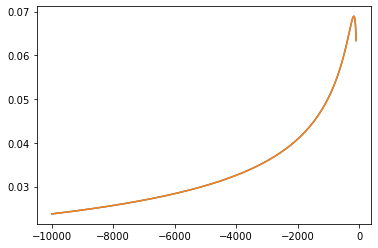

In [11]:
plt.figure()
plt.plot(t, omega)
plt.plot(t, omega_jit)
plt.show()

In [12]:
%%timeit
omega = gwjax.taylort3.TaylorT3_Omega_new(t, tc, eta, M)

3.12 ms ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
omega_jit = t3_omega_jit(t, tc, eta, M)

166 µs ± 533 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
3.4e-3 / 176e-6

19.318181818181817

In [15]:
t3_omega_jit_vmap = vmap(jit(gwjax.taylort3.TaylorT3_Omega_new), in_axes=(None, 0, 0, 0), out_axes=0)

In [16]:
N = 10

key = random.PRNGKey(0)

t = jnp.linspace(-10000, -1000, 1000)

# t = jnp.row_stack((t,t))

tc_array = random.uniform(key, (N,), minval=-100, maxval=-50)
eta_array = random.uniform(key, (N,), minval=0.01, maxval=0.25)
M_array = jnp.ones(N)

In [17]:
tc_array

DeviceArray([-57.2911674 , -91.68997196, -86.19725756, -75.63592173,
             -50.39779452, -98.49200429, -89.18528091, -81.15643489,
             -68.46497816, -51.92776138], dtype=float64)

In [18]:
eta_array

DeviceArray([0.2150024 , 0.04988813, 0.07625316, 0.12694758, 0.24809059,
             0.01723838, 0.06191065, 0.10044911, 0.1613681 , 0.24074675],            dtype=float64)

In [19]:
t.shape

(1000,)

In [20]:
omega_jit_vmap = t3_omega_jit_vmap(t, tc_array, eta_array, M_array)

In [21]:
%%timeit
omega_jit_vmap = t3_omega_jit_vmap(t, tc_array, eta_array, M_array)

388 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
omega_jit_vmap.shape

(10, 1000)

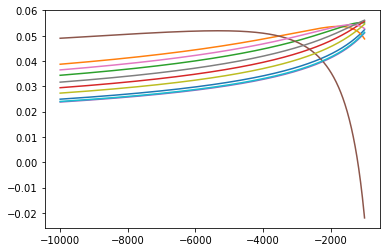

In [23]:
plt.figure()
for om in omega_jit_vmap:
    plt.plot(t, om)

In [24]:
# check the vectorisation worked but looping over by hand
omega_array = jnp.asarray([t3_omega_jit(t, a,b,c) for (a,b,c) in zip(tc_array, eta_array, M_array)])

In [25]:
%%timeit
omega_array = jnp.asarray([t3_omega_jit(t, a,b,c) for (a,b,c) in zip(tc_array, eta_array, M_array)])

3.53 ms ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
omega_array.shape

(10, 1000)

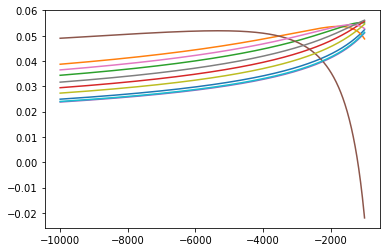

In [27]:
plt.figure()
for om in omega_array:
    plt.plot(t, om)

In [28]:
for i in range(N):
    print(rmse(omega_jit_vmap[i], omega_array[i]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [29]:
rmse_jit_vmap = vmap(jit(rmse), in_axes=(0,0))

In [30]:
# we can also jit and vmap the rmse function too
rmse_jit_vmap(omega_jit_vmap, omega_array)

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [31]:
%%timeit
rmse_jit_vmap(omega_jit_vmap, omega_array)

275 µs ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# example with grad

In [48]:
grad_tanh = vmap(grad(jnp.tanh))

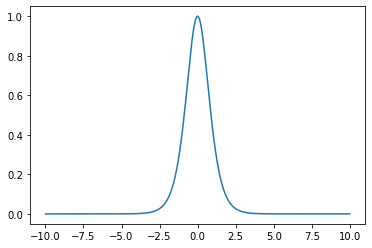

In [49]:
x = jnp.linspace(-10, 10, 1000)
plt.figure()
plt.plot(x, grad_tanh(x))

In [ ]:
# can compute the time derivative like this

In [101]:
omega_grad = vmap(jit(grad(gwjax.taylort3.TaylorT3_Omega_new, 0)), in_axes=(0, None, None, None))

In [102]:
omega_grad

<function gwjax.taylort3.api_boundary.<locals>.reraise_with_filtered_traceback(t, tc, eta, M)>

In [103]:
%%timeit
omega_grad(t, tc, eta, M)

350 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


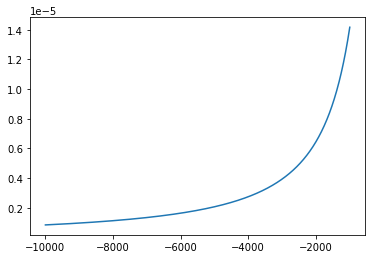

In [93]:
plt.figure()
plt.plot(t, omega_grad(t, tc, eta, M))

In [94]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [95]:
y = gwjax.taylort3.TaylorT3_Omega_new(t, tc, eta, M)

In [99]:
%%timeit
IUS(t, y).derivative()(t)

194 µs ± 5.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [96]:
dy = IUS(t, y).derivative()(t)

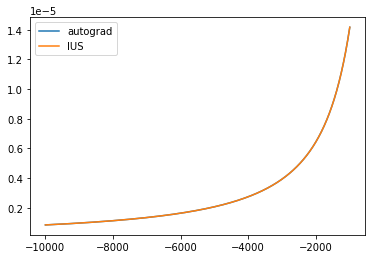

In [104]:
plt.figure()
plt.plot(t, omega_grad(t, tc, eta, M), label='autograd')
plt.plot(t, dy, label='IUS')
plt.legend()